In [4]:
%%capture
!pip install -r requirements.txt

In [5]:
%%capture
!pip install qwen-vl-utils 

In [59]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info


model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", torch_dtype="auto", device_map="auto", 
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
messages_eiffel = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image":  "eiffel.jpeg",
            },
            {"type": "text", "text": """Describe the follwing image in terms of objects present and any famous landmarks you see.
        """},
        ],
    }
]



In [8]:
asian_landmarks = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image":  "lalbagh_fort.jpeg",
            },
            {"type": "text", "text": """Describe the follwing image in terms of objects present and any famous landmarks you see.
        """},
        ],
    }
]


In [9]:
def get_vlm_response(messages):
    text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    print(text)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text


In [60]:
def get_vlm_response_text(messages):
    text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(
        text=[text],
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text


In [11]:
response = get_vlm_response(messages_eiffel)
response

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Describe the follwing image in terms of objects present and any famous landmarks you see.
        <|im_end|>
<|im_start|>assistant



['The image depicts the Eiffel Tower, a famous landmark located in Paris, France. The Eiffel Tower is a wrought iron lattice tower that stands 324 meters (1,063 feet) tall and is the most recognizable symbol of Paris. It was designed by Gustave Eiffel and completed in 1889. The tower is situated in the Champ de Mars park, which is a large green space in the heart of the city. The sky in the image is clear and blue, indicating a sunny day. The Eiffel Tower is the central focus of the image, and it is surrounded']

In [12]:
response = get_vlm_response(asian_landmarks)
response

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Describe the follwing image in terms of objects present and any famous landmarks you see.
        <|im_end|>
<|im_start|>assistant



['The image depicts the Shalimar Bagh, a historic garden and mosque complex located in Srinagar, Jammu and Kashmir, India. The Shalimar Bagh is a UNESCO World Heritage Site and is known for its stunning architecture and serene atmosphere. The image shows the main entrance of the complex, which features a large, ornate gate with a central archway and two smaller archways flanking it. The gate is made of red sandstone and is adorned with intricate carvings and sculptures.\n\nIn front of the gate, there is a large, rectangular pool with a fountain in the center. The pool is filled with']

In [62]:
extract_entities = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": f"Extract the entities such as landmarks from the given text {response} and output the entity names only."},
        ],
    }
]

In [63]:
entities = get_vlm_response_text(extract_entities)
entities

['Shalimar Bagh, Srinagar, Jammu and Kashmir, India, UNESCO World Heritage Site, Shalimar Bagh, main entrance, large ornate gate, central archway, two smaller archways, red sandstone, intricate carvings, sculptures, large rectangular pool, fountain, filled with water']

# Construct our simple knowledge graph 

In [15]:
import networkx as nx

G = nx.Graph()
G.add_edge('Lalbagh fort', 'Dhaka', relation='Located In')
G.add_edge('Dhaka', 'Bangladesh', relation='Capital Of')
G.add_edge('Lalbagh fort', 'mosque', relation='religious structure')
G.add_edge('Lalbagh fort', 'historical building', relation='landmark type')

{('Lalbagh fort',
  'Dhaka'): Text(0.10282975377773917, -0.019845164094296874, 'Located In'),
 ('Lalbagh fort',
  'mosque'): Text(-0.4574902940799965, -0.14160178708430549, 'religious structure'),
 ('Lalbagh fort',
  'historical building'): Text(-0.3729990599724063, 0.29599030399839865, 'landmark type'),
 ('Dhaka',
  'Bangladesh'): Text(0.7166654049936365, -0.1335692236353911, 'Capital Of')}

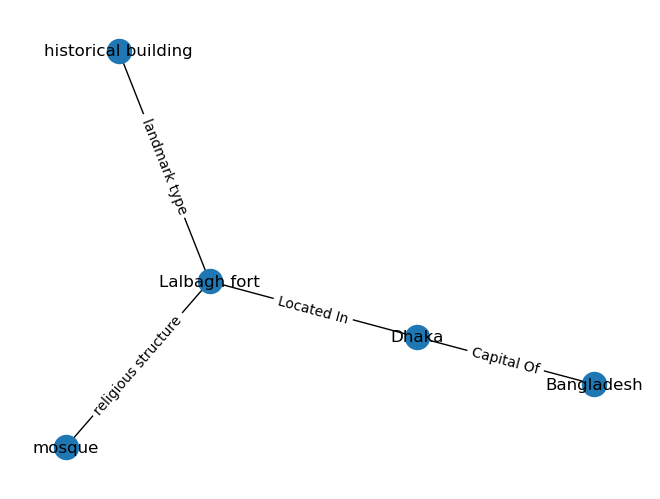

In [16]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Apply a post processing strategy to correct the generated text

In [17]:
%%capture
!pip install spacy


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
%%capture
!python -m spacy download en_core_web_sm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
import spacy
from spacy.tokens import Span

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    """
    Extract entities from the text using spaCy's NER model.
    
    Args:
        text (str): Input text.
        
    Returns:
        dict: A dictionary where keys are entity types and values are lists of entities of that type.
    """
    doc = nlp(text)
    entities = {}
    
    for ent in doc.ents:
        if ent.label_ not in entities:
            entities[ent.label_] = [ent.text]
        else:
            entities[ent.label_].append(ent.text)
    
    return entities

def highlight_entities(text):
    """
    Highlight entities in the text by enclosing them in square brackets with entity type.
    
    Args:
        text (str): Input text.
        
    Returns:
        str: Text with entities highlighted.
    """
    doc = nlp(text)
    
    highlighted_text = text
    offset = 0  # Offset to track position shifts as we insert entity types
    
    for ent in doc.ents:
        entity_string = f"[{ent.text} ({ent.label_})]"
        start = ent.start_char + offset
        end = ent.end_char + offset
        
        # Replace the entity with the highlighted version
        highlighted_text = highlighted_text[:start] + entity_string + highlighted_text[end:]
        offset += len(entity_string) - len(ent.text)  # Adjust offset by difference in lengths
    
    return highlighted_text


In [39]:
# Extract entities
entities = extract_entities(response[0])
print("Extracted Entities:", entities)


Extracted Entities: {'FAC': ['the Shalimar Bagh'], 'GPE': ['Srinagar', 'Jammu', 'Kashmir', 'India'], 'PERSON': ['The Shalimar Bagh'], 'ORG': ['UNESCO World Heritage Site'], 'CARDINAL': ['two']}


In [21]:
highlighted_text = highlight_entities(response[0])
print("Highlighted Text:", highlighted_text)

Highlighted Text: The image depicts [the Shalimar Bagh (FAC)], a historic garden and mosque complex located in [Srinagar (GPE)], [Jammu (GPE)] and [Kashmir (GPE)], [India (GPE)]. [The Shalimar Bagh (PERSON)] is a [UNESCO World Heritage Site (ORG)] and is known for its stunning architecture and serene atmosphere. The image shows the main entrance of the complex, which features a large, ornate gate with a central archway and [two (CARDINAL)] smaller archways flanking it. The gate is made of red sandstone and is adorned with intricate carvings and sculptures.

In front of the gate, there is a large, rectangular pool with a fountain in the center. The pool is filled with


In [26]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


# Check entities against the knowledge graph
def find_entity_in_graph(entity, G):
    return entity if entity in G.nodes else None

# Find the most similar entity from the graph using embeddings
def find_closest_entity(entity, G, model):
    graph_entities = list(G.nodes)
    entity_embeddings = model.encode([entity])
    graph_embeddings = model.encode(graph_entities)
    similarities = cosine_similarity(entity_embeddings, graph_embeddings).flatten()
    best_match_index = similarities.argmax()
    best_match_score = similarities[best_match_index]
    return graph_entities[best_match_index] if best_match_score > 0.5 else None  # Adjust the threshold as needed



In [27]:
# Load a pre-trained model for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [42]:
generated_entities = [entity for entity_list in entities.values() for entity in entity_list]

In [49]:
corrected_entities = []
for entity in generated_entities:
    if find_entity_in_graph(entity, G):
        corrected_entities.append(entity)
    else:
        # Try to find a close match if the entity is not in the graph
        closest_entity = find_closest_entity(entity, G, model)
        if closest_entity:
            corrected_entities.append(closest_entity)
        else:
            # If no close match is found, consider it hallucinated and choose an appropriate action
            corrected_entities.append(f"[Hallucinated Entity: {entity}]")




In [50]:
corrected_entities

['[Hallucinated Entity: the Shalimar Bagh]',
 'Dhaka',
 '[Hallucinated Entity: Jammu]',
 'Bangladesh',
 'Bangladesh',
 '[Hallucinated Entity: The Shalimar Bagh]',
 '[Hallucinated Entity: UNESCO World Heritage Site]',
 '[Hallucinated Entity: two]']

In [51]:
# Display the corrected generation
corrected_text = response[0]
for hallucinated, corrected in zip(generated_entities, corrected_entities):
    corrected_text = corrected_text.replace(hallucinated, corrected)

print("Corrected Generation:")
print(corrected_text)

Corrected Generation:
The image depicts [Hallucinated Entity: the Shalimar Bagh], a historic garden and mosque complex located in Dhaka, [Hallucinated Entity: Jammu] and Bangladesh, Bangladesh. [Hallucinated Entity: The Shalimar Bagh] is a [Hallucinated Entity: UNESCO World Heritage Site] and is known for its stunning architecture and serene atmosphere. The image shows the main entrance of the complex, which features a large, ornate gate with a central archway and [Hallucinated Entity: two] smaller archways flanking it. The gate is made of red sandstone and is adorned with intricate carvings and sculptures.

In front of the gate, there is a large, rectangular pool with a fountain in the center. The pool is filled with


# Context augmentation to make the llm correct its generation

In [52]:
def graph_to_natural_language(graph, target_entity=None):
    facts = []
    for source, target, data in graph.edges(data=True):
        if target_entity and target_entity not in [source, target]:
            continue  # Skip if not relevant to the target entity
        relation = data['relation']
        facts.append(f"{source} {relation} {target}.")
    return " ".join(facts)

# Generate natural language facts for the entire graph
context = graph_to_natural_language(G)
print("Graph Knowledge in Natural Language:")
print(context)

Graph Knowledge in Natural Language:
Lalbagh fort Located In Dhaka. Lalbagh fort religious structure mosque. Lalbagh fort landmark type historical building. Dhaka Capital Of Bangladesh.


In [53]:
def graph_to_bullet_points(graph, target_entity=None):
    bullet_points = []
    for source, target, data in graph.edges(data=True):
        if target_entity and target_entity not in [source, target]:
            continue
        relation = data['relation']
        bullet_points.append(f"- {source}: {relation} {target}")
    return "\n".join(bullet_points)

# Generate bullet points for a specific entity or the entire graph
bullet_points_context = graph_to_bullet_points(G)
print("Graph Knowledge in Bullet Points:")
print(bullet_points_context)

Graph Knowledge in Bullet Points:
- Lalbagh fort: Located In Dhaka
- Lalbagh fort: religious structure mosque
- Lalbagh fort: landmark type historical building
- Dhaka: Capital Of Bangladesh


In [55]:
def graph_to_triples(graph, target_entity=None):
    triples = []
    for source, target, data in graph.edges(data=True):
        if target_entity and target_entity not in [source, target]:
            continue
        relation = data['relation']
        triples.append((source, relation, target))
    return triples

triples_context = graph_to_triples(G)
print("Graph Knowledge in Triples:")
for triple in triples_context:
    print(triple)


Graph Knowledge in Triples:
('Lalbagh fort', 'Located In', 'Dhaka')
('Lalbagh fort', 'religious structure', 'mosque')
('Lalbagh fort', 'landmark type', 'historical building')
('Dhaka', 'Capital Of', 'Bangladesh')


In [54]:
def graph_to_hierarchical(graph, target_entity=None, level=0):
    hierarchical_representation = ""
    visited = set()
    def traverse(node, level):
        nonlocal hierarchical_representation
        if node in visited:
            return
        visited.add(node)
        prefix = "  " * level + "- "
        hierarchical_representation += f"{prefix}{node}\n"
        for neighbor in graph.neighbors(node):
            relation = graph[node][neighbor]['relation']
            hierarchical_representation += f"{'  ' * (level + 1)}- {relation}: {neighbor}\n"
            traverse(neighbor, level + 2)
    
    if target_entity:
        traverse(target_entity, level)
    else:
        for node in graph.nodes:
            traverse(node, level)
    return hierarchical_representation

hierarchical_context = graph_to_hierarchical(G)
print("Hierarchical Representation of Graph Knowledge:")
print(hierarchical_context)


Hierarchical Representation of Graph Knowledge:
- Lalbagh fort
  - Located In: Dhaka
    - Dhaka
      - Located In: Lalbagh fort
      - Capital Of: Bangladesh
        - Bangladesh
          - Capital Of: Dhaka
  - religious structure: mosque
    - mosque
      - religious structure: Lalbagh fort
  - landmark type: historical building
    - historical building
      - landmark type: Lalbagh fort



In [64]:
response_correction = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": f"""Use the knowledge from the context provided here {bullet_points_context} to correct the 
             facts in this response {response[0]}. Output the corrected response."""},
        ],
    }
]

In [65]:
corrected_captions = get_vlm_response_text(response_correction)
corrected_captions

['The image depicts the Lalbagh fort, a historic building located in Dhaka, Bangladesh. The Lalbagh fort is a religious structure, specifically a mosque. The fort is a landmark type of historical building, and it is situated in the heart of Dhaka. The image shows the main entrance of the Lalbagh fort, which features a large, ornate gate with a central archway and two smaller archways flanking it. The gate is made of red sandstone and is adorned with intricate carvings and sculptures. In front of the gate, there is a large, rectangular pool with a fountain in the center.']

In [66]:
response_correction_hierarchical = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": f"""Use the knowledge from the context provided here {hierarchical_context} to correct the 
             facts in this response {response[0]}. Output the corrected response."""},
        ],
    }
]

In [67]:
corrected_captions_with_hierarchy = get_vlm_response_text(response_correction_hierarchical)
corrected_captions_with_hierarchy

['The image depicts the Lalbagh fort, a historic building located in Dhaka, Bangladesh. The Lalbagh fort is a UNESCO World Heritage Site and is known for its rich history and architectural beauty. The image shows the main entrance of the complex, which features a large, ornate gate with a central archway and two smaller archways flanking it. The gate is made of red sandstone and is adorned with intricate carvings and sculptures. In front of the gate, there is a large, rectangular pool with a fountain in the center. The pool is filled with water and is surrounded by a stone pathway.']

In [68]:
response_correction_triplets = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": f"""Use the knowledge from the context provided here {triples_context} to correct the 
             facts in this response {response[0]}. Output the corrected response."""},
        ],
    }
]

In [69]:
corrected_captions_with_triples = get_vlm_response_text(response_correction_triplets)
corrected_captions_with_triples

['The image depicts the Lalbagh fort, a historic garden and mosque complex located in Dhaka, Bangladesh. The Lalbagh fort is a UNESCO World Heritage Site and is known for its stunning architecture and serene atmosphere. The image shows the main entrance of the complex, which features a large, ornate gate with a central archway and two smaller archways flanking it. The gate is made of red sandstone and is adorned with intricate carvings and sculptures. In front of the gate, there is a large, rectangular pool with a fountain in the center.']

In [22]:
import torch
torch.cuda.empty_cache()